# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Loading the data

In [2]:
df = pd.read_csv("../data/labeled_data.csv", encoding = "utf8")

In [3]:
df_trump = pd.read_csv("../data/trump_tweet.csv", encoding = "utf8")

In [4]:
df_trump.columns

Index([u'Unnamed: 0', u'tweet', u'created_at', u'retweet_count',
       u'followers_count'],
      dtype='object')

In [5]:
#df = pickle.load(open("../data/labeled_data.p",'rb'))

In [6]:
df_trump.head()

,Unnamed: 0,tweet,created_at,retweet_count,followers_count
0,1,Will be leaving Florida for Washington (D.C.) ...,Mon Jan 01 13:37:52 +0000 2018,8237,45551365
1,2,Iran is failing at every level despite the ter...,Mon Jan 01 12:44:40 +0000 2018,14595,45551365
2,3,The United States has foolishly given Pakistan...,Mon Jan 01 12:12:00 +0000 2018,49566,45551365
3,4,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,Sun Dec 31 23:43:04 +0000 2017,35164,45551365
4,5,As our Country rapidly grows stronger and smar...,Sun Dec 31 22:18:20 +0000 2017,39428,45551365


In [7]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [9]:
df.columns

Index([        u'Unnamed: 0',              u'count',        u'hate_speech',
       u'offensive_language',            u'neither',              u'class',
                    u'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


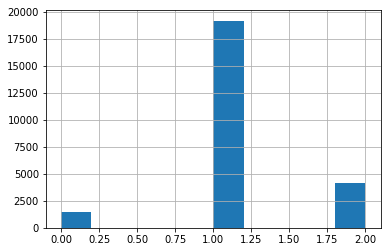

In [10]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [11]:
trump_tweets = df_trump.tweet

In [12]:
print type(trump_tweets[1])

<type 'unicode'>


In [13]:
trump_tweets.head()

0    Will be leaving Florida for Washington (D.C.) ...
1    Iran is failing at every level despite the ter...
2    The United States has foolishly given Pakistan...
3    HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
4    As our Country rapidly grows stronger and smar...
Name: tweet, dtype: object

In [14]:
tweets=df.tweet

In [15]:
print type(tweets[1])
print type(tweets)

<type 'unicode'>
<class 'pandas.core.series.Series'>


In [16]:
train_len = len(tweets)
print train_len

24783


In [17]:
print tweets.head()
print trump_tweets.head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object
0    Will be leaving Florida for Washington (D.C.) ...
1    Iran is failing at every level despite the ter...
2    The United States has foolishly given Pakistan...
3    HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...
4    As our Country rapidly grows stronger and smar...
Name: tweet, dtype: object


In [18]:
tweets = pd.concat([tweets, trump_tweets.astype('U')] , axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

print type(tweets[100])
print type(tweets[31880])



# df.columns.get_values()
#total_rows['ColumnID'] = total_rows['ColumnID'].astype(str)

<type 'unicode'>
<type 'unicode'>


In [105]:
tweets = trump_tweets.astype('U')

In [106]:
len(tweets)

31881

In [106]:
type(tweets[31880])

str

In [127]:
print type(tweets[100])
print tweets[100]

TypeError: 'instancemethod' object has no attribute '__getitem__'

In [ ]:
#print pd.DataFrame(data={'tweet':tweets[31880]})


d = {'col1': [1, 2], 'col2': [3, 4]}
print 
#pd.DataFrame(data=d)


## Feature generation

In [19]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [20]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [21]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [22]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [23]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [24]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [25]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [26]:
feats = get_feature_array(tweets)

In [27]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [28]:
M.shape

(57580, 15017)

In [29]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.iteritems():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.iteritems():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [30]:
TR = M[:24783,:]

In [31]:
TE = M[24783:,:]

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [32]:
X = pd.DataFrame(TR)
y = df['class'].astype(int)

In [33]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15007,15008,15009,15010,15011,15012,15013,15014,15015,15016
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,23.0,0.000,0.120,0.880,0.4563,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,16.0,0.237,0.000,0.763,-0.6876,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,18.0,0.538,0.000,0.462,-0.9550,0.0,2.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,8.0,0.000,0.344,0.656,0.5673,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,23.0,0.249,0.081,0.669,-0.7762,1.0,1.0,0.0,0.0


In [34]:
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01))
X_ = select.fit_transform(X,y)

In [35]:
X_

array([[ 0.    ,  0.    ,  0.    , ...,  0.4563,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    , ..., -0.6876,  0.    ,  1.    ],
       [ 0.    ,  0.    ,  0.    , ..., -0.955 ,  0.    ,  2.    ],
       ..., 
       [ 0.    ,  0.    ,  0.    , ...,  0.4738,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ..., -0.7717,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.5994,  0.    ,  0.    ]])

In [36]:
X_.shape

(24783, 178)

In [37]:
model = LinearSVC(class_weight='balanced',C=0.01, penalty='l2', loss='squared_hinge',multi_class='ovr').fit(X_, y)

In [38]:
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01).fit(X_,y)

In [39]:
y_preds = model.predict(X_)

In [40]:
y_preds

array([2, 1, 1, ..., 1, 1, 2])

In [41]:
#Trump predictions 
Xt = pd.DataFrame(TE)

In [42]:
Xt_ = select.transform(Xt)

In [43]:
Xt_.shape

(32797, 178)

In [44]:
trump_preds = model.predict(Xt_)

In [45]:
print trump_preds

[2 2 2 ..., 2 2 2]


In [46]:
unique, counts = np.unique(trump_preds, return_counts=True)

In [47]:
print unique 
print counts

[0 1 2]
[  124    97 32576]


In [48]:
df_trump.head()

,Unnamed: 0,tweet,created_at,retweet_count,followers_count
0,1,Will be leaving Florida for Washington (D.C.) ...,Mon Jan 01 13:37:52 +0000 2018,8237,45551365
1,2,Iran is failing at every level despite the ter...,Mon Jan 01 12:44:40 +0000 2018,14595,45551365
2,3,The United States has foolishly given Pakistan...,Mon Jan 01 12:12:00 +0000 2018,49566,45551365
3,4,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,Sun Dec 31 23:43:04 +0000 2017,35164,45551365
4,5,As our Country rapidly grows stronger and smar...,Sun Dec 31 22:18:20 +0000 2017,39428,45551365


In [49]:
final_df_trump = pd.concat([df_trump,pd.DataFrame(trump_preds) ] , axis=1, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [50]:
final_df_trump.head()

,0,1,2,3,4,5
0,1,Will be leaving Florida for Washington (D.C.) ...,Mon Jan 01 13:37:52 +0000 2018,8237,45551365,2
1,2,Iran is failing at every level despite the ter...,Mon Jan 01 12:44:40 +0000 2018,14595,45551365,2
2,3,The United States has foolishly given Pakistan...,Mon Jan 01 12:12:00 +0000 2018,49566,45551365,2
3,4,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,Sun Dec 31 23:43:04 +0000 2017,35164,45551365,2
4,5,As our Country rapidly grows stronger and smar...,Sun Dec 31 22:18:20 +0000 2017,39428,45551365,2


In [51]:
final_df_trump.columns

RangeIndex(start=0, stop=6, step=1)

In [52]:
final_df_trump.rename(index=str, columns={0:'Unnamed: 0', 1:'tweet', 2:'created_at', 3:'retweet_count', 4:'followers_count', 5:'label'})

#Index([u'Unnamed: 0', u'tweet', u'created_at', u'retweet_count',
#       u'followers_count'],
#      dtype='object')

,Unnamed: 0,tweet,created_at,retweet_count,followers_count,label
0,1,Will be leaving Florida for Washington (D.C.) ...,Mon Jan 01 13:37:52 +0000 2018,8237,45551365,2
1,2,Iran is failing at every level despite the ter...,Mon Jan 01 12:44:40 +0000 2018,14595,45551365,2
2,3,The United States has foolishly given Pakistan...,Mon Jan 01 12:12:00 +0000 2018,49566,45551365,2
3,4,HAPPY NEW YEAR! We are MAKING AMERICA GREAT AG...,Sun Dec 31 23:43:04 +0000 2017,35164,45551365,2
4,5,As our Country rapidly grows stronger and smar...,Sun Dec 31 22:18:20 +0000 2017,39428,45551365,2
5,6,"Iran, the Number One State of Sponsored Terror...",Sun Dec 31 22:00:21 +0000 2017,27984,45551365,2
6,7,"What a year it’s been, and we're just getting ...",Sun Dec 31 19:06:52 +0000 2017,26433,45551365,2
7,8,My deepest condolences to the victims of the t...,Sun Dec 31 18:36:28 +0000 2017,16989,45551365,2
8,9,Why would smart voters want to put Democrats i...,Sun Dec 31 13:36:32 +0000 2017,25981,45551365,2
9,10,"If the Dems (Crooked Hillary) got elected, you...",Sun Dec 31 13:26:29 +0000 2017,14449,45551365,2


In [62]:
header = ["Unnamed: 0", "tweet", "created_at", "retweet_count", "followers_count", "label"]
final_df_trump.to_csv('final_trump_labels', header = True, encoding='utf-8')

In [206]:

final_df_trump.to_csv('final_trump_labels', sep='\t', encoding='utf-8')

In [209]:
import os 
os.getcwd()

'/Users/amir/Dropbox/MSIM/INFX573/Course_Project/twitter-hate-speech-identification/src'

## Evaluating the results

In [33]:
report = classification_report( y, y_preds )

In [34]:
print(report)

             precision    recall  f1-score   support

          0       0.44      0.60      0.51      1430
          1       0.97      0.91      0.94     19190
          2       0.81      0.95      0.88      4163

avg / total       0.91      0.90      0.90     24783



In [212]:
import pylab as plt
import matplotlib
plt.switch_backend('PS') 
matplotlib.use('PS')

In [213]:
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'


#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In [215]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']

In [220]:
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))

In [222]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.unicode']=True

string = r'z=${value}^{upper}_{lower}$'.format(
                value='{' + str(0.27) + '}',
                upper='{+' + str(0.01) + '}',
                lower='{-' + str(0.01) + '}')
print(string)
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')


z=${0.27}^{+0.01}_{-0.01}$


AttributeError: 'FigureCanvasPS' object has no attribute 'get_renderer'

RuntimeError: LaTeX was not able to process the following string:
'lp'
Here is the full report generated by LaTeX: 



In [ ]:
plt.ylabel(r'\textbf{True categories}',fontsize=14)
plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.tick_params(labelsize=12)

In [ ]:
#True distribution
y.hist()

In [ ]:
pd.Series(y_preds).hist()